### Knowledge graph-driven decision support system

In [1]:
import numpy as np
import pandas as pd
import requests
import rasterio
from rasterio.windows import Window
from pyproj import Transformer
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
from pystac_client import Client

from rdflib import Graph, Namespace, Literal
from rdflib.plugins.sparql import prepareQuery
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
# Namespaces
she = Namespace("https://soilwise-he.github.io/soil-health#")
agrovoc = Namespace("http://aims.fao.org/aos/agrovoc/")
agrontology = Namespace("http://aims.fao.org/aos/agrontology#")
sio = Namespace("http://semanticscience.org/resource/")
glosis_lh = Namespace("http://w3id.org/glosis/model/layerhorizon/")
glosis_sp = Namespace("http://w3id.org/glosis/model/siteplot/")
qudt = Namespace("http://qudt.org/schema/qudt/")
unit = Namespace("http://qudt.org/vocab/unit/")
iso11074 = Namespace("https://data.geoscience.earth/ncl/ISO11074v2025/")
obo = Namespace("http://purl.obolibrary.org/obo/")
wdt = Namespace("http://www.wikidata.org/prop/direct/")
biolink = Namespace("https://w3id.org/biolink/vocab/")
afox = Namespace("http://purl.allotrope.org/ontologies/property#")
afor = Namespace("http://purl.allotrope.org/ontologies/result#")
sorelsc = Namespace("http://sweetontology.net/relaSci/")
sorelpr = Namespace("http://sweetontology.net/relaProvenance/")
sohuj = Namespace("http://sweetontology.net/humanJurisdiction/")
sorelph = Namespace("http://sweetontology.net/relaPhysical/")
sorelm = Namespace("http://sweetontology.net/relaMath/")
sorepsg = Namespace("http://sweetontology.net/reprSpaceGeometry/")
bao = Namespace("http://www.bioassayontology.org/bao#")
repr = Namespace("https://w3id.org/reproduceme#")
sorelch = Namespace("http://sweetontology.net/relaChemical/")
sorelsp = Namespace("http://sweetontology.net/relaSpace/")
om = Namespace("http://www.ontology-of-units-of-measure.org/resource/om-2/")
gemet = Namespace("http://www.eionet.europa.eu/gemet/concept/")
inrae = Namespace("http://opendata.inrae.fr/thesaurusINRAE/")

#### Access to EcoDataCube digital soil mapping

EcoDataCube Soil Data Access - Wageningen, Netherlands

1. Soil Organic Carbon Time Series (Surface, 0cm)
----------------------------------------
Fetching data for 2000-2003...
Fetching data for 2004-2007...
Fetching data for 2008-2011...
Fetching data for 2012-2015...
Fetching data for 2016-2019...
Fetching data for 2020...

Soil Organic Carbon (%) over time:
      period      value      error
0  2000-2003  18.863600  23.118113
1  2004-2007  20.232978  27.368767
2  2008-2011  19.766338  19.598355
3  2012-2015  21.950353  58.592005
4  2016-2019  21.445971  23.204735
5       2020  20.470216  17.667098

2. Soil Organic Carbon Profile (2020)
----------------------------------------
Fetching surface...
Fetching subsoil_30...
Fetching subsoil_60...
Fetching subsoil_100...

Soil Organic Carbon (%) by depth:
    depth_name  depth_cm      value
0      surface         0  20.470216
1   subsoil_30        30  12.463738
2   subsoil_60        60   3.481689
3  subsoil_100       100   2.966078

✓ Plo

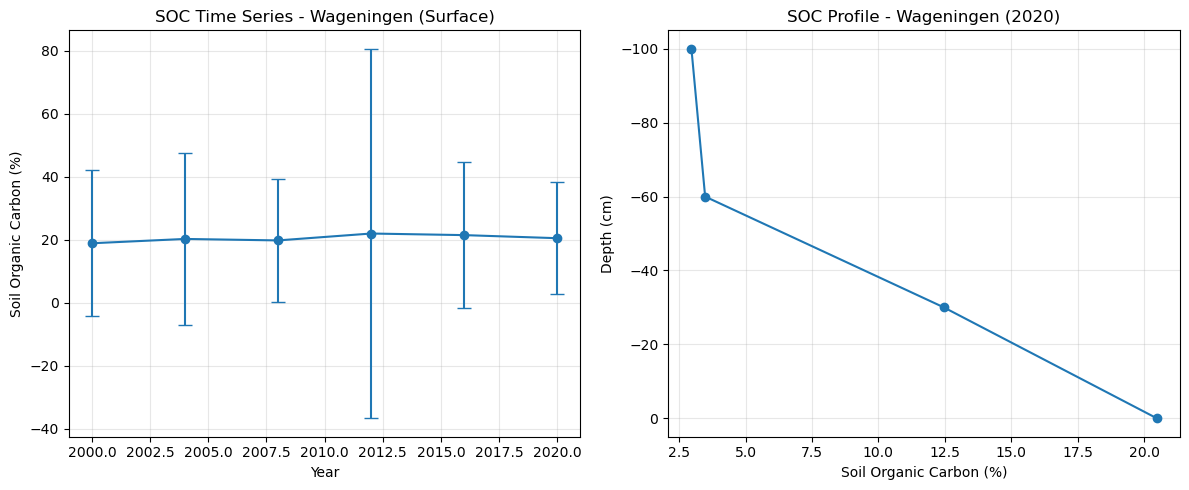

In [105]:
"""
EcoDataCube Soil Data Access Script
====================================
This script demonstrates how to access soil data from EcoDataCube.eu,
specifically soil organic carbon data for Wageningen, Netherlands.

EcoDataCube provides soil data at 30m resolution for Europe with temporal coverage
from 2000-2020 in the following periods: 2000-2003, 2004-2007, 2008-2011, 
2012-2015, 2016-2019, and 2020.

Author: Assistant
Date: 2025
"""

warnings.filterwarnings('ignore')

class EcoDataCubeClient:
    """
    Client for accessing EcoDataCube soil data.
    
    The data is stored as Cloud-Optimized GeoTIFFs on Wasabi S3 storage
    and can be accessed directly via URLs or through STAC API.
    """
    
    def __init__(self):
        """Initialize the EcoDataCube client with base URLs and metadata."""
        self.base_url = "https://s3.eu-central-1.wasabisys.com/eumap/sol/"
        self.stac_url = "https://stac.ecodatacube.eu"
        
        # Available soil properties
        self.soil_properties = {
            'organic_carbon': 'sol_log.oc_lucas.iso.10694',
            'ph': 'sol_ph.h2o_lucas.iso.10694',
            'clay': 'sol_clay.tot.psa_lucas.iso.10694',
            'sand': 'sol_sand.tot.psa_lucas.iso.10694',
            'bulk_density': 'sol_db.od_lucas.iso.10694'
        }
        
        # Available depths
        self.depths = {
            'surface': 's0..0cm',
            'subsoil_30': 's30..30cm',
            'subsoil_60': 's60..60cm',
            'subsoil_100': 's100..100cm'
        }
        
        # Available time periods
        self.periods = {
            2000: '2000-2003',
            2004: '2004-2007',
            2008: '2008-2011',
            2012: '2012-2015',
            2016: '2016-2019',
            2020: '2020'
        }
        
        # Estimation types
        self.estimation_types = {
            'mean': 'm',
            'error': 'md'
        }
        
    def build_url(self, property_name, depth, year, estimation_type='mean'):
        """
        Build the URL for accessing a specific soil layer.
        
        Parameters:
        -----------
        property_name : str
            Name of soil property ('organic_carbon', 'ph', 'clay', 'sand', 'bulk_density')
        depth : str
            Depth level ('surface', 'subsoil_30', 'subsoil_60', 'subsoil_100')
        year : int
            Year (2000, 2004, 2008, 2012, 2016, 2020)
        estimation_type : str
            Type of estimation ('mean' or 'error')
            
        Returns:
        --------
        str : Complete URL to the GeoTIFF file
        """
        prop_code = self.soil_properties[property_name]
        depth_code = self.depths[depth]
        est_code = self.estimation_types[estimation_type]
        
        url = f"{self.base_url}{prop_code}_{est_code}_30m_{depth_code}_{year}_eumap_epsg3035_v0.2.tif"
        return url
    
    def transform_coordinates(self, lat, lon):
        """
        Transform WGS84 coordinates to EPSG:3035 (European Albers Equal Area).
        
        Parameters:
        -----------
        lat : float
            Latitude in WGS84
        lon : float
            Longitude in WGS84
            
        Returns:
        --------
        tuple : (x, y) coordinates in EPSG:3035
        """
        transformer = Transformer.from_crs("EPSG:4326", "EPSG:3035", always_xy=True)
        x, y = transformer.transform(lon, lat)
        return x, y
    
    def extract_point_value(self, url, lat, lon, window_size=1):
        """
        Extract soil value at a specific point location.
        
        Parameters:
        -----------
        url : str
            URL to the GeoTIFF file
        lat : float
            Latitude of the point
        lon : float
            Longitude of the point
        window_size : int
            Size of window around point (1 = single pixel, 3 = 3x3 window)
            
        Returns:
        --------
        float : Extracted value (or mean of window)
        """
        # Transform coordinates
        x, y = self.transform_coordinates(lat, lon)
        
        try:
            with rasterio.open(url) as src:
                # Get pixel coordinates
                row, col = src.index(x, y)
                
                # Define window
                window = Window(col - window_size//2, row - window_size//2, 
                              window_size, window_size)
                
                # Read data
                data = src.read(1, window=window)
                
                # Handle nodata values
                nodata = src.nodata
                if nodata is not None:
                    data = np.where(data == nodata, np.nan, data)
                
                # Return mean value
                return np.nanmean(data)
                
        except Exception as e:
            print(f"Error accessing {url}: {e}")
            return None
    
    def transform_organic_carbon(self, log_oc_value):
        """
        Transform log organic carbon to actual SOC percentage.
        
        The data is stored as log-transformed values to reduce skewness.
        Formula: SOC% = (exp(x/10) - 1)
        
        Parameters:
        -----------
        log_oc_value : float
            Log-transformed organic carbon value
            
        Returns:
        --------
        float : Soil organic carbon percentage
        """
        if log_oc_value is None or np.isnan(log_oc_value):
            return None
        return (np.exp(log_oc_value / 10) - 1)
    
    def get_time_series(self, lat, lon, property_name='organic_carbon', 
                       depth='surface', window_size=3):
        """
        Get time series of soil property for a specific location.
        
        Parameters:
        -----------
        lat : float
            Latitude of the location
        lon : float
            Longitude of the location
        property_name : str
            Name of soil property
        depth : str
            Depth level
        window_size : int
            Size of extraction window
            
        Returns:
        --------
        pd.DataFrame : Time series data
        """
        results = []
        
        for year, period in self.periods.items():
            print(f"Fetching data for {period}...")
            
            # Get mean value
            url_mean = self.build_url(property_name, depth, year, 'mean')
            value = self.extract_point_value(url_mean, lat, lon, window_size)
            
            # Get error estimate
            url_error = self.build_url(property_name, depth, year, 'error')
            error = self.extract_point_value(url_error, lat, lon, window_size)
            
            # Transform if organic carbon
            if property_name == 'organic_carbon' and value is not None:
                value = self.transform_organic_carbon(value)
                # Error is also in log scale, transform it
                if error is not None:
                    # Approximate error transformation
                    error = value * (np.exp(error/10) - 1)
            
            results.append({
                'year': year,
                'period': period,
                'value': value,
                'error': error,
                'property': property_name,
                'depth': depth
            })
        
        return pd.DataFrame(results)
    
    def get_soil_profile(self, lat, lon, property_name='organic_carbon', year=2020):
        """
        Get soil profile (values at different depths) for a location.
        
        Parameters:
        -----------
        lat : float
            Latitude of the location
        lon : float
            Longitude of the location
        property_name : str
            Name of soil property
        year : int
            Year of interest
            
        Returns:
        --------
        pd.DataFrame : Soil profile data
        """
        results = []
        
        for depth_name, depth_code in self.depths.items():
            print(f"Fetching {depth_name}...")
            
            url = self.build_url(property_name, depth_name, year, 'mean')
            value = self.extract_point_value(url, lat, lon, window_size=3)
            
            # Transform if organic carbon
            if property_name == 'organic_carbon' and value is not None:
                value = self.transform_organic_carbon(value)
            
            # Extract depth value for plotting
            if depth_name == 'surface':
                depth_cm = 0
            else:
                depth_cm = int(depth_code.split('s')[1].split('..')[0])
            
            results.append({
                'depth_name': depth_name,
                'depth_cm': depth_cm,
                'value': value,
                'property': property_name,
                'year': year
            })
        
        return pd.DataFrame(results)
    
    def download_area(self, lat_min, lat_max, lon_min, lon_max, 
                     property_name='organic_carbon', depth='surface', 
                     year=2020, output_file='soil_data.tif'):
        """
        Download soil data for a rectangular area.
        
        Parameters:
        -----------
        lat_min, lat_max : float
            Latitude bounds
        lon_min, lon_max : float
            Longitude bounds
        property_name : str
            Name of soil property
        depth : str
            Depth level
        year : int
            Year of interest
        output_file : str
            Output filename
            
        Returns:
        --------
        bool : Success status
        """
        try:
            # Transform bounding box corners
            x_min, y_min = self.transform_coordinates(lat_min, lon_min)
            x_max, y_max = self.transform_coordinates(lat_max, lon_max)
            
            # Ensure correct ordering (x_min < x_max, y_min < y_max)
            if x_min > x_max:
                x_min, x_max = x_max, x_min
            if y_min > y_max:
                y_min, y_max = y_max, y_min
            
            url = self.build_url(property_name, depth, year, 'mean')
            
            with rasterio.open(url) as src:
                # Calculate pixel coordinates for bounds
                col_min = int((x_min - src.transform.c) / src.transform.a)
                col_max = int((x_max - src.transform.c) / src.transform.a)
                row_min = int((y_max - src.transform.f) / src.transform.e)
                row_max = int((y_min - src.transform.f) / src.transform.e)
                
                # Ensure indices are within raster bounds
                col_min = max(0, col_min)
                col_max = min(src.width, col_max)
                row_min = max(0, row_min)
                row_max = min(src.height, row_max)
                
                width = col_max - col_min
                height = row_max - row_min
                
                if width <= 0 or height <= 0:
                    print("Error: Invalid window size")
                    return False
                
                window = Window(col_min, row_min, width, height)
                data = src.read(1, window=window)
                
                # Use window transform (this is the key that works)
                new_transform = src.window_transform(window)
                
                # Create simple profile manually (exactly as in working version)
                profile = {
                    'driver': 'GTiff',
                    'dtype': src.dtypes[0],
                    'nodata': src.nodata,
                    'width': width,
                    'height': height,
                    'count': 1,
                    'crs': src.crs,
                    'transform': new_transform
                }
                
                # Write to file
                with rasterio.open(output_file, 'w', **profile) as dst:
                    dst.write(data, 1)
                
                print(f"Data saved to {output_file}")
                print(f"Area: {width}x{height} pixels")
                
                # Calculate and display actual geographic bounds
                bounds = rasterio.transform.array_bounds(height, width, new_transform)
                print(f"Geographic bounds: X({bounds[0]:.2f}, {bounds[2]:.2f}), Y({bounds[1]:.2f}, {bounds[3]:.2f})")
                return True
            
        except Exception as e:
            print(f"Error downloading area: {e}")
            import traceback
            traceback.print_exc()
            return False


def main():
    """
    Main function demonstrating EcoDataCube usage for Wageningen, Netherlands.
    """
    # Initialize client
    client = EcoDataCubeClient()
    
    # Wageningen coordinates (approximately)
    wageningen_lat = 51.9700  # Latitude
    wageningen_lon = 5.6667   # Longitude
    
    print("=" * 60)
    print("EcoDataCube Soil Data Access - Wageningen, Netherlands")
    print("=" * 60)
    
    # 1. Get soil organic carbon time series (2015 approximated by 2016 period)
    print("\n1. Soil Organic Carbon Time Series (Surface, 0cm)")
    print("-" * 40)
    
    soc_timeseries = client.get_time_series(
        lat=wageningen_lat,
        lon=wageningen_lon,
        property_name='organic_carbon',
        depth='surface',
        window_size=3  # 3x3 pixel window for more robust estimate
    )
    
    print("\nSoil Organic Carbon (%) over time:")
    print(soc_timeseries[['period', 'value', 'error']].to_string())
    
    # 2. Get soil profile for 2020
    print("\n2. Soil Organic Carbon Profile (2020)")
    print("-" * 40)
    
    soc_profile = client.get_soil_profile(
        lat=wageningen_lat,
        lon=wageningen_lon,
        property_name='organic_carbon',
        year=2020
    )
    
    print("\nSoil Organic Carbon (%) by depth:")
    print(soc_profile[['depth_name', 'depth_cm', 'value']].to_string())
    
    # 3. Plot time series
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Time series plot
    valid_data = soc_timeseries.dropna(subset=['value'])
    ax1.errorbar(valid_data['year'], valid_data['value'], 
                yerr=valid_data['error'], fmt='o-', capsize=5)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Soil Organic Carbon (%)')
    ax1.set_title('SOC Time Series - Wageningen (Surface)')
    ax1.grid(True, alpha=0.3)
    
    # Profile plot
    valid_profile = soc_profile.dropna(subset=['value'])
    ax2.plot(valid_profile['value'], -valid_profile['depth_cm'], 'o-')
    ax2.set_xlabel('Soil Organic Carbon (%)')
    ax2.set_ylabel('Depth (cm)')
    ax2.set_title('SOC Profile - Wageningen (2020)')
    ax2.grid(True, alpha=0.3)
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('wageningen_soil_analysis.png', dpi=150, bbox_inches='tight')
    print("\n✓ Plots saved to 'wageningen_soil_analysis.png'")
    
    # 4. Get additional soil properties
    print("\n3. Multiple Soil Properties (2020, Surface)")
    print("-" * 40)
    
    properties_data = []
    for prop in ['organic_carbon', 'ph', 'clay', 'sand']:
        url = client.build_url(prop, 'surface', 2020, 'mean')
        value = client.extract_point_value(url, wageningen_lat, wageningen_lon, 3)
        
        # Transform organic carbon
        if prop == 'organic_carbon' and value is not None:
            value = client.transform_organic_carbon(value)
            unit = '%'
        elif prop == 'ph':
            unit = ''
        else:
            unit = '%'
        
        properties_data.append({
            'Property': prop.replace('_', ' ').title(),
            'Value': f"{value:.2f}{unit}" if value else 'N/A'
        })
    
    properties_df = pd.DataFrame(properties_data)
    print("\n" + properties_df.to_string(index=False))
    
    # 5. Download a small area around Wageningen (optional)
    print("\n4. Download Area Data (Optional)")
    print("-" * 40)
    
    # Define a small bounding box around Wageningen (approximately 5x5 km)
    download = input("\nDownload 5x5km area around Wageningen? (y/n): ").lower()
    
    if download == 'y':
        success = client.download_area(
            lat_min=wageningen_lat - 0.025,
            lat_max=wageningen_lat + 0.025,
            lon_min=wageningen_lon - 0.04,
            lon_max=wageningen_lon + 0.04,
            property_name='organic_carbon',
            depth='surface',
            year=2020,
            output_file='wageningen_soc_2020.tif'
        )
        
        if success:
            print("✓ Area data downloaded successfully!")
    
    print("\n" + "=" * 60)
    print("Analysis complete!")
    print("\nNotes:")
    print("- Data from 2016-2019 period approximates 2015 conditions")
    print("- All data at 30m spatial resolution")
    print("- Original data in EPSG:3035 projection")
    print("- Source: OpenGeoHub/EcoDataCube.eu")
    print("=" * 60)


# Alternative method using STAC API (requires pystac-client)
def access_via_stac():
    """
    Alternative method to access EcoDataCube via STAC API.
    Note: This requires the pystac-client library.
    """
    try:
        # Connect to STAC API with the correct catalog.json endpoint
        catalog = Client.open("https://s3.ecodatacube.eu/arco/stac/catalog.json")
        
        # Search for items
        print("STAC Catalog connected successfully!")
        print(f"Catalog ID: {catalog.id}")
        print(f"Description: {catalog.description}")
        
        # List available collections
        collections = list(catalog.get_collections())
        print(f"\nFound {len(collections)} collections:")
        for collection in collections:
            print(f"- {collection.id}: {collection.title}")
            
    except ImportError:
        print("pystac-client not installed. Install with: pip install pystac-client")
    except Exception as e:
        print(f"Error accessing STAC API: {e}")
        print("Trying alternative STAC endpoints...")
        
        # Try alternative endpoints
        alternative_urls = [
            "https://stac.ecodatacube.eu/catalog.json",
            "https://ecodatacube.eu/stac/catalog.json",
            "https://s3.eu-central-1.wasabisys.com/ecodatacube/stac/catalog.json"
        ]
        
        for url in alternative_urls:
            try:
                print(f"Trying: {url}")
                catalog = Client.open(url)
                print(f"✅ Success with: {url}")
                break
            except Exception as alt_e:
                print(f"❌ Failed: {alt_e}")


if __name__ == "__main__":
    main()
    
    # Uncomment to test STAC access
    print("\n\nTesting STAC API Access:")
    access_via_stac()

In [106]:
"""
EcoDataCube Quick Start - Minimal Example
==========================================
Simple script to get soil organic carbon data for Wageningen from EcoDataCube
"""


def get_soil_organic_carbon(lat, lon, year=2020):
    """
    Get soil organic carbon for a specific location and year.
    
    Available years: 2000, 2004, 2008, 2012, 2016, 2020
    """
    # Transform coordinates from WGS84 to EPSG:3035 (European projection)
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3035", always_xy=True)
    x, y = transformer.transform(lon, lat)
    
    # Build URL for soil organic carbon (surface, 0cm depth)
    # Format: sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_YEAR_eumap_epsg3035_v0.2.tif
    url = f"https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_{year}_eumap_epsg3035_v0.2.tif"
    
    print(f"Accessing: {url}")
    
    try:
        # Open the Cloud-Optimized GeoTIFF directly from URL
        with rasterio.open(url) as src:
            # Get pixel coordinates for our location
            row, col = src.index(x, y)
            
            # Read a 3x3 window around the point for robustness
            window = rasterio.windows.Window(col - 1, row - 1, 3, 3)
            data = src.read(1, window=window)
            
            # Get the mean value (filtering out nodata)
            nodata = src.nodata
            if nodata is not None:
                data = np.where(data == nodata, np.nan, data)
            
            log_oc_value = np.nanmean(data)
            
            # Transform from log scale to actual SOC percentage
            # Formula: SOC% = exp(x/10) - 1
            soc_percentage = (np.exp(log_oc_value / 10) - 1)
            
            return soc_percentage
            
    except Exception as e:
        print(f"Error: {e}")
        return None


def main():
    """
    Example: Get soil organic carbon for Wageningen over time
    """
    # Wageningen, Netherlands coordinates
    wageningen_lat = 51.9700
    wageningen_lon = 5.6667
    
    print("Soil Organic Carbon in Wageningen, Netherlands")
    print("=" * 50)
    
    # Get data for available years
    years = [2000, 2004, 2008, 2012, 2016, 2020]
    
    for year in years:
        soc = get_soil_organic_carbon(wageningen_lat, wageningen_lon, year)
        if soc is not None:
            period = {
                2000: "2000-2003",
                2004: "2004-2007", 
                2008: "2008-2011",
                2012: "2012-2015",
                2016: "2016-2019",  # This approximates 2015 data
                2020: "2020"
            }[year]
            print(f"{period}: {soc:.2f}% SOC")
    
    print("\nNote: 2016-2019 period approximates conditions around 2015")


# Additional example: Get multiple soil properties
def get_all_soil_properties(lat, lon, year=2020):
    """
    Get all available soil properties for a location.
    """
    # Transform coordinates
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3035", always_xy=True)
    x, y = transformer.transform(lon, lat)
    
    base_url = "https://s3.eu-central-1.wasabisys.com/eumap/sol/"
    
    properties = {
        'Organic Carbon (%)': {
            'file': f'sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_{year}_eumap_epsg3035_v0.2.tif',
            'transform': lambda x: (np.exp(x / 10) - 1)  # Log transform
        },
        'pH': {
            'file': f'sol_ph.h2o_lucas.iso.10694_m_30m_s0..0cm_{year}_eumap_epsg3035_v0.2.tif',
            'transform': lambda x: x  # No transform needed
        },
        'Clay Content (%)': {
            'file': f'sol_clay.tot.psa_lucas.iso.10694_m_30m_s0..0cm_{year}_eumap_epsg3035_v0.2.tif',
            'transform': lambda x: x  # No transform needed
        },
        'Sand Content (%)': {
            'file': f'sol_sand.tot.psa_lucas.iso.10694_m_30m_s0..0cm_{year}_eumap_epsg3035_v0.2.tif',
            'transform': lambda x: x  # No transform needed
        },
        'Bulk Density (kg/m³)': {
            'file': f'sol_db.od_lucas.iso.10694_m_30m_s0..0cm_{year}_eumap_epsg3035_v0.2.tif',
            'transform': lambda x: x * 10  # Convert from 10 kg/m³ units
        }
    }
    
    results = {}
    
    for prop_name, prop_info in properties.items():
        url = base_url + prop_info['file']
        
        try:
            with rasterio.open(url) as src:
                row, col = src.index(x, y)
                window = rasterio.windows.Window(col - 1, row - 1, 3, 3)
                data = src.read(1, window=window)
                
                # Handle nodata
                nodata = src.nodata
                if nodata is not None:
                    data = np.where(data == nodata, np.nan, data)
                
                value = np.nanmean(data)
                
                # Apply transformation
                value = prop_info['transform'](value)
                results[prop_name] = value
                
        except Exception as e:
            results[prop_name] = None
            print(f"Error getting {prop_name}: {e}")
    
    return results


# Example with error bands
def get_with_uncertainty(lat, lon, year=2020):
    """
    Get soil organic carbon with uncertainty estimates.
    """
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3035", always_xy=True)
    x, y = transformer.transform(lon, lat)
    
    base_url = "https://s3.eu-central-1.wasabisys.com/eumap/sol/"
    
    # URLs for mean and error
    mean_url = base_url + f"sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_{year}_eumap_epsg3035_v0.2.tif"
    error_url = base_url + f"sol_log.oc_lucas.iso.10694_md_30m_s0..0cm_{year}_eumap_epsg3035_v0.2.tif"
    
    results = {}
    
    for url, key in [(mean_url, 'mean'), (error_url, 'error')]:
        try:
            with rasterio.open(url) as src:
                row, col = src.index(x, y)
                window = rasterio.windows.Window(col - 1, row - 1, 3, 3)
                data = src.read(1, window=window)
                
                nodata = src.nodata
                if nodata is not None:
                    data = np.where(data == nodata, np.nan, data)
                
                value = np.nanmean(data)
                
                # Transform from log scale
                if key == 'mean':
                    results[key] = (np.exp(value / 10) - 1)
                else:
                    # Approximate error transformation
                    results[key] = results.get('mean', 0) * (np.exp(value/10) - 1)
                    
        except Exception as e:
            results[key] = None
    
    return results


if __name__ == "__main__":
    main()
    
    print("\n" + "=" * 50)
    print("Getting all soil properties for Wageningen (2020):")
    print("-" * 50)
    
    all_props = get_all_soil_properties(51.9700, 5.6667, 2020)
    for prop, value in all_props.items():
        if value is not None:
            if 'Density' in prop:
                print(f"{prop}: {value:.0f}")
            else:
                print(f"{prop}: {value:.2f}")
    
    print("\n" + "=" * 50)
    print("Getting SOC with uncertainty (2020):")
    print("-" * 50)
    
    uncertainty = get_with_uncertainty(51.9700, 5.6667, 2020)
    if uncertainty['mean'] is not None:
        print(f"SOC: {uncertainty['mean']:.2f}% ± {uncertainty.get('error', 0):.2f}%")

Soil Organic Carbon in Wageningen, Netherlands
Accessing: https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2000_eumap_epsg3035_v0.2.tif
2000-2003: 18.86% SOC
Accessing: https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2004_eumap_epsg3035_v0.2.tif
2004-2007: 20.23% SOC
Accessing: https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2008_eumap_epsg3035_v0.2.tif
2008-2011: 19.77% SOC
Accessing: https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2012_eumap_epsg3035_v0.2.tif
2012-2015: 21.95% SOC
Accessing: https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2016_eumap_epsg3035_v0.2.tif
2016-2019: 21.45% SOC
Accessing: https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2020_eumap_epsg3035_v0.2.tif
2020: 20.47% SOC

Note: 2016-2019 period approximates conditions arou

#### Soil properties analysis

Starting comprehensive soil property analysis for Wageningen...
COMPREHENSIVE SOIL ANALYSIS - WAGENINGEN AREA
Area bounds: Lat 51.9400 to 52.0000, Lon 5.6367 to 5.6967
Approximate area: 6km x 6km at 30m resolution

Processing Soil Organic Carbon...
Data saved to wageningen_soc.tif
Area: 150x214 pixels
Geographic bounds: X(4021140.00, 4025640.00), Y(3212320.00, 3218740.00)
  Mean: 26.24 %
  Std:  7.10 %
  Range: 8.97 - 48.40 %

Processing pH (H2O)...
Data saved to wageningen_ph.tif
Area: 150x214 pixels
Geographic bounds: X(4021140.00, 4025640.00), Y(3212320.00, 3218740.00)
  Mean: 6.05 
  Std:  0.45 
  Range: 4.40 - 7.20 

Processing Clay Content...
Data saved to wageningen_clay.tif
Area: 150x214 pixels
Geographic bounds: X(4021140.00, 4025640.00), Y(3212320.00, 3218740.00)
  Mean: 15.41 %
  Std:  5.18 %
  Range: 4.00 - 32.00 %

Processing Sand Content...
Data saved to wageningen_sand.tif
Area: 150x214 pixels
Geographic bounds: X(4021140.00, 4025640.00), Y(3212320.00, 3218740.00)
  Mean

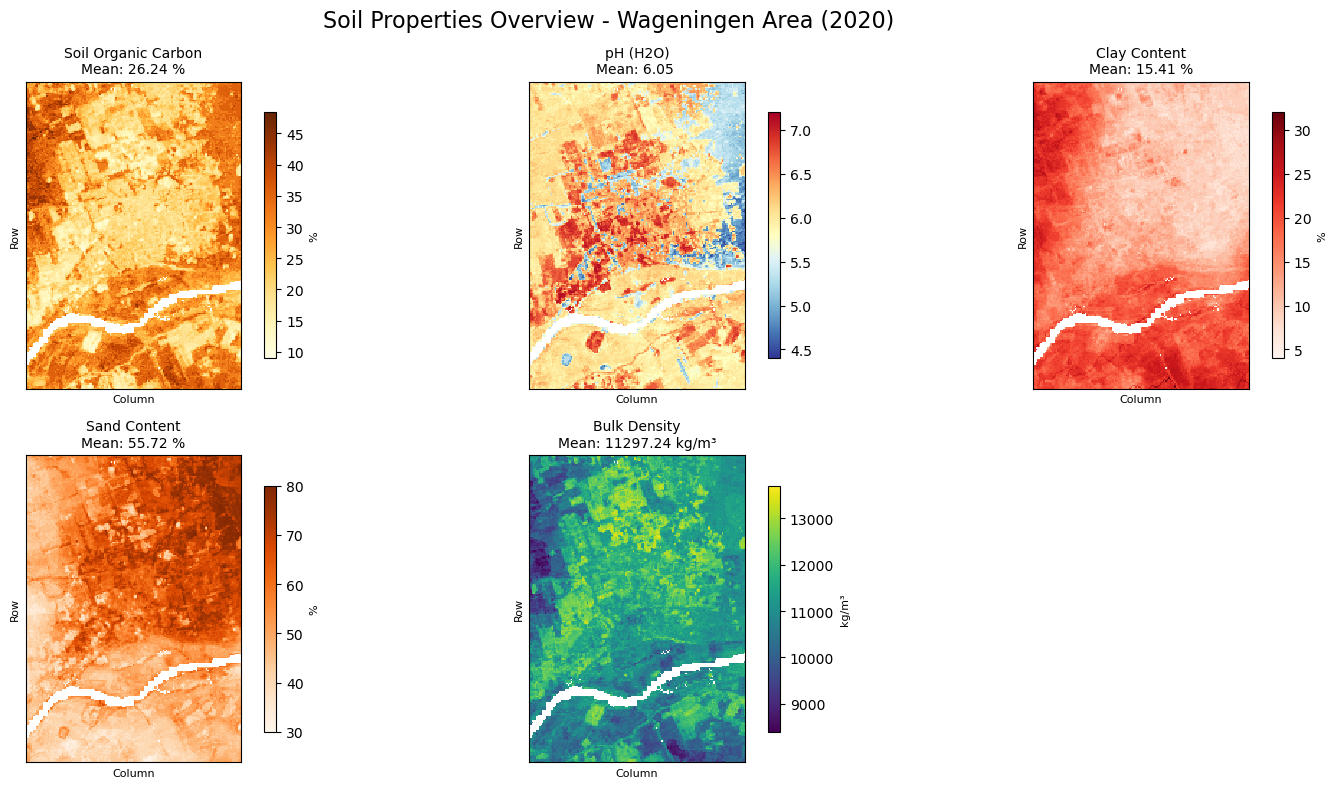


ANALYSIS COMPLETE!
Generated files:
- Comprehensive overview: wageningen_soil_overview.png
- Raw data files: wageningen_*.tif


In [107]:
def analyze_wageningen_all_properties(client):
    """
    Comprehensive analysis of all soil properties for Wageningen area.
    """
    # Wageningen city bounds (same as before)
    center_lat = 51.9700
    center_lon = 5.6667
    buffer = 0.03  # roughly 3km in each direction
    
    lat_min = center_lat - buffer
    lat_max = center_lat + buffer  
    lon_min = center_lon - buffer
    lon_max = center_lon + buffer
    
    print("=" * 80)
    print("COMPREHENSIVE SOIL ANALYSIS - WAGENINGEN AREA")
    print("=" * 80)
    print(f"Area bounds: Lat {lat_min:.4f} to {lat_max:.4f}, Lon {lon_min:.4f} to {lon_max:.4f}")
    print(f"Approximate area: 6km x 6km at 30m resolution")
    
    # Define all available soil properties with their transformations
    soil_properties = {
        'Soil Organic Carbon': {
            'property': 'organic_carbon',
            'filename': 'wageningen_soc.tif',
            'transform': lambda x: np.exp(x / 10) - 1,  # Log transform
            'unit': '%',
            'colormap': 'YlOrBr',
            'description': 'Soil Organic Carbon content'
        },
        'pH (H2O)': {
            'property': 'ph',
            'filename': 'wageningen_ph.tif',
            'transform': lambda x: x / 10,  # pH is stored as pH*10
            'unit': '',
            'colormap': 'RdYlBu_r',
            'description': 'Soil pH in water'
        },
        'Clay Content': {
            'property': 'clay',
            'filename': 'wageningen_clay.tif',
            'transform': lambda x: x,  # Already in percentage
            'unit': '%',
            'colormap': 'Reds',
            'description': 'Clay content (particles < 2μm)'
        },
        'Sand Content': {
            'property': 'sand',
            'filename': 'wageningen_sand.tif',
            'transform': lambda x: x,  # Already in percentage
            'unit': '%',
            'colormap': 'Oranges',
            'description': 'Sand content (particles 50μm-2mm)'
        },
        'Bulk Density': {
            'property': 'bulk_density',
            'filename': 'wageningen_bulk_density.tif',
            'transform': lambda x: x * 100,  # Convert from cg/cm³ to kg/m³
            'unit': 'kg/m³',
            'colormap': 'viridis',
            'description': 'Soil bulk density'
        }
    }
    
    # Download and process each property
    all_data = {}
    
    for prop_name, prop_info in soil_properties.items():
        print(f"\nProcessing {prop_name}...")
        
        # Download the area data
        success = client.download_area(
            lat_min=lat_min,
            lat_max=lat_max,
            lon_min=lon_min,
            lon_max=lon_max,
            property_name=prop_info['property'],
            depth='surface',
            year=2020,
            output_file=prop_info['filename']
        )
        
        if success:
            # Read and process the data
            with rasterio.open(prop_info['filename']) as src:
                data = src.read(1)
                
                # Handle nodata
                nodata = src.nodata
                if nodata is not None:
                    data = np.where(data == nodata, np.nan, data)
                
                # Apply transformation
                processed_data = prop_info['transform'](data)
                
                # Store data and metadata
                all_data[prop_name] = {
                    'data': processed_data,
                    'transform': src.transform,
                    'crs': src.crs,
                    'info': prop_info
                }
                
                # Calculate statistics
                print(f"  Mean: {np.nanmean(processed_data):.2f} {prop_info['unit']}")
                print(f"  Std:  {np.nanstd(processed_data):.2f} {prop_info['unit']}")
                print(f"  Range: {np.nanmin(processed_data):.2f} - {np.nanmax(processed_data):.2f} {prop_info['unit']}")
        else:
            print(f"  ❌ Failed to download {prop_name}")
    
    return all_data

def create_soil_texture_analysis(all_data):
    """
    Analyze soil texture distribution (text output only).
    """
    if 'Clay Content' in all_data and 'Sand Content' in all_data:
        print("\n" + "=" * 60)
        print("SOIL TEXTURE ANALYSIS")
        print("=" * 60)
        
        clay_data = all_data['Clay Content']['data']
        sand_data = all_data['Sand Content']['data']
        
        # Calculate silt content (assuming clay + sand + silt = 100%)
        silt_data = 100 - clay_data - sand_data
        
        # Flatten data and remove NaN values
        clay_flat = clay_data.flatten()
        sand_flat = sand_data.flatten()
        silt_flat = silt_data.flatten()
        
        # Create mask for valid data
        valid_mask = ~(np.isnan(clay_flat) | np.isnan(sand_flat) | np.isnan(silt_flat))
        
        clay_valid = clay_flat[valid_mask]
        sand_valid = sand_flat[valid_mask]
        silt_valid = silt_flat[valid_mask]
        
        # Create texture classification
        def classify_texture(clay, sand, silt):
            """Simple texture classification based on USDA system"""
            if clay >= 40:
                return "Clay"
            elif clay >= 27 and sand <= 45:
                return "Clay Loam"
            elif clay >= 20 and sand >= 45:
                return "Sandy Clay Loam"
            elif clay >= 7 and sand >= 52:
                return "Sandy Loam"
            elif sand >= 85:
                return "Sand"
            elif sand >= 70:
                return "Loamy Sand"
            elif silt >= 80:
                return "Silt"
            elif silt >= 50:
                return "Silt Loam"
            else:
                return "Loam"
        
        # Classify textures
        textures = [classify_texture(c, s, si) for c, s, si in zip(clay_valid, sand_valid, silt_valid)]
        
        # Count texture classes
        from collections import Counter
        texture_counts = Counter(textures)
        
        print("Soil Texture Distribution:")
        for texture, count in texture_counts.most_common():
            percentage = (count / len(textures)) * 100
            print(f"  {texture}: {count} pixels ({percentage:.1f}%)")
        
        print(f"\nSoil Texture Statistics:")
        print(f"  Clay: {np.nanmean(clay_valid):.1f}% ± {np.nanstd(clay_valid):.1f}%")
        print(f"  Sand: {np.nanmean(sand_valid):.1f}% ± {np.nanstd(sand_valid):.1f}%") 
        print(f"  Silt: {np.nanmean(silt_valid):.1f}% ± {np.nanstd(silt_valid):.1f}%")

def create_comprehensive_overview(all_data):
    """
    Create a comprehensive overview with all properties in one figure.
    """
    print("\n" + "=" * 60)
    print("CREATING COMPREHENSIVE OVERVIEW")
    print("=" * 60)
    
    n_props = len(all_data)
    if n_props == 0:
        print("No data to plot")
        return
    
    # Calculate grid layout
    cols = min(3, n_props)
    rows = (n_props + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    
    if n_props == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if isinstance(axes, list) else [axes]
    else:
        axes = axes.flatten()
    
    for i, (prop_name, prop_data) in enumerate(all_data.items()):
        ax = axes[i]
        data = prop_data['data']
        info = prop_data['info']
        
        # Create the plot
        im = ax.imshow(data, cmap=info['colormap'], interpolation='nearest')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=0.8)
        cbar.set_label(f"{info['unit']}", fontsize=8)
        
        # Set title
        ax.set_title(f"{prop_name}\nMean: {np.nanmean(data):.2f} {info['unit']}", 
                    fontsize=10)
        ax.set_xlabel('Column', fontsize=8)
        ax.set_ylabel('Row', fontsize=8)
        
        # Remove tick labels to save space
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Hide empty subplots
    for i in range(n_props, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('Soil Properties Overview - Wageningen Area (2020)', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.savefig('wageningen_soil_overview.png', dpi=150, bbox_inches='tight')
    print("✓ Saved: wageningen_soil_overview.png")
    plt.show()

# Run the comprehensive analysis
print("Starting comprehensive soil property analysis for Wageningen...")

# Initialize client
client = EcoDataCubeClient()

# Get all soil property data
all_data = analyze_wageningen_all_properties(client)

if all_data:
    # Create texture analysis (text only)
    create_soil_texture_analysis(all_data)
    
    # Create comprehensive overview (single image)
    create_comprehensive_overview(all_data)
    
    print("\n" + "=" * 80)
    print("ANALYSIS COMPLETE!")
    print("=" * 80)
    print("Generated files:")
    print("- Comprehensive overview: wageningen_soil_overview.png")
    print("- Raw data files: wageningen_*.tif")
else:
    print("❌ No data could be retrieved. Please check your internet connection and try again.")

COMPREHENSIVE SOIL pH ANALYSIS - WAGENINGEN AREA

1. QUERYING KNOWLEDGE GRAPH FOR SOIL pH THRESHOLDS
--------------------------------------------------
Knowledge graph loaded with 11715 triples
Querying Knowledge Graph for pH thresholds and constraints:

1. pH Ranges and Constraints:
  soil pH greaterThan: 5.5 - beneficial for crop production
  soil pH greaterThan: 6.0 - beneficial for crop production
  soil pH smallerThan: 5.5-6.0 - constrains crop production
  soil pH http://sweetontology.net/relaMath/hasLowerBound: 5 - Unknown
  soil pH http://sweetontology.net/relaMath/hasThreshold: 4.5 - critical for aluminium toxicity

2. Aluminium Release Conditions:
  soil pH smallerThan: 4.5 (causes aluminium release in agricultural soils)

Extracted numerical thresholds from KG: [4.5, 5.0, 5.5, 6.0]

2. DEFINING pH CLASSIFICATION SYSTEM
--------------------------------------------------
pH Classification System (based on Knowledge Graph):
  Toxic        pH < 4.5    - Aluminium toxicity risk
 

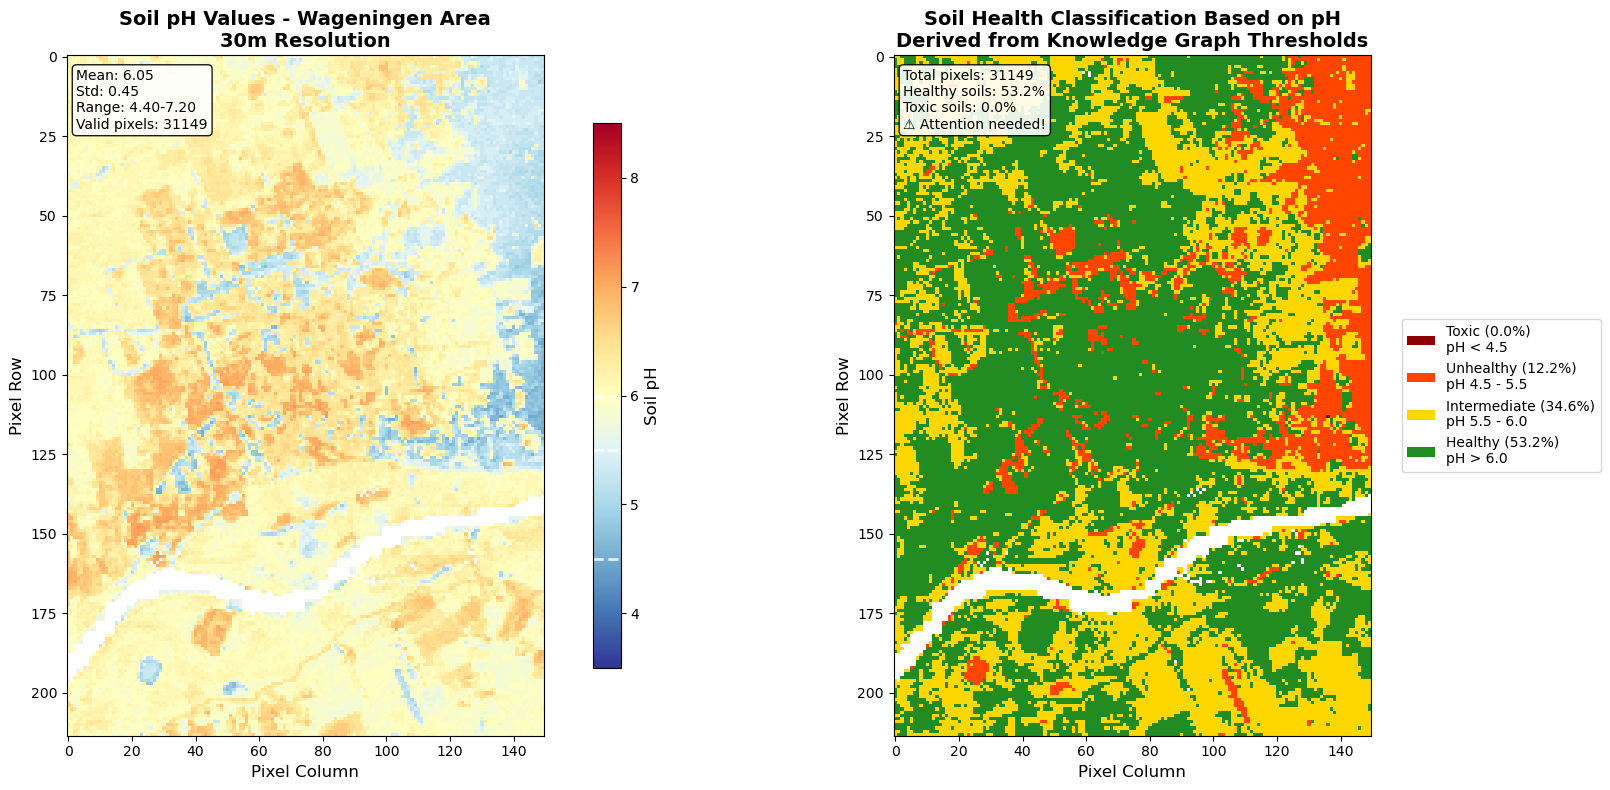


6. SUMMARY REPORT
SOIL pH HEALTH ASSESSMENT - WAGENINGEN AREA
Analysis based on Knowledge Graph thresholds
Spatial resolution: 30m x 30m pixels
Total area analyzed: ~2803.4 hectares

SOIL HEALTH DISTRIBUTION:
Overall status: GOOD
  Toxic       :   0.0% (   0.1 ha) - Aluminium toxicity risk
  Unhealthy   :  12.2% ( 341.9 ha) - Below beneficial range
  Intermediate:  34.6% ( 970.9 ha) - Optimal range for crops
  Healthy     :  53.2% (1490.5 ha) - Above optimal range

KEY FINDINGS:
ℹ️  NOTE: 34.6% of soils are in optimal crop production range

✓ Analysis completed successfully!
✓ Results saved as 'wageningen_soil_ph_analysis.png'


In [108]:
# Comprehensive Soil pH Analysis: Knowledge Graph Query + Spatial Visualization
print("=" * 80)
print("COMPREHENSIVE SOIL pH ANALYSIS - WAGENINGEN AREA")
print("=" * 80)

# Step 1: Load and Query Knowledge Graph for pH Thresholds
print("\n1. QUERYING KNOWLEDGE GRAPH FOR SOIL pH THRESHOLDS")
print("-" * 50)


# Load the knowledge graph if not already loaded
try:
    # Check if g is already defined from previous cells
    if 'g' not in globals():
        g = Graph()
        g.parse('soil_health_KG.ttl', format='turtle')
    print(f"Knowledge graph loaded with {len(g)} triples")
except Exception as e:
    print(f"Error loading knowledge graph: {e}")
    g = None

# Enhanced SPARQL query to extract pH thresholds from the KG
if g is not None:
    
    # SPARQL query based on the competency question about soil pH ranges
    ph_ranges_query = """
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
    PREFIX she: <https://soilwise-he.github.io/soil-health#>
    PREFIX agrontology: <http://aims.fao.org/aos/agrontology#>
    PREFIX sorelm: <http://sweetontology.net/relaMath/>
    PREFIX qudt: <http://qudt.org/schema/qudt/>
    PREFIX obo: <http://purl.obolibrary.org/obo/>

    SELECT ?pH_Context ?relationshipOrLimitType ?valueOrRange ?relatedConditionLabel
    WHERE {
      {
        she:SoilpH skos:prefLabel ?phLabel_1 .
        she:SoilpH agrontology:smallerThan ?constraintNode .
        ?constraintNode obo:RO_0002212 she:CropProduction .
        she:CropProduction skos:prefLabel ?cpLabel_1 .
        ?constraintNode sorelm:hasInterval ?interval .

        BIND(?phLabel_1 AS ?pH_Context)
        BIND(agrontology:smallerThan AS ?relationshipOrLimitType)
        BIND(?interval AS ?valueOrRange)
        BIND(CONCAT("constrains ", ?cpLabel_1) AS ?relatedConditionLabel)
      }
      UNION
      {
        she:SoilpH skos:prefLabel ?phLabel_2 .
        she:SoilpH sorelm:hasLowerBound ?lowerBoundValueSimple .
        BIND(?phLabel_2 AS ?pH_Context)
        BIND(sorelm:hasLowerBound AS ?relationshipOrLimitType)
        BIND(STR(?lowerBoundValueSimple) AS ?valueOrRange)
      }
      UNION
      {
        she:SoilpH skos:prefLabel ?phLabel_3 .
        she:SoilpH sorelm:hasThreshold ?criticalNode .
        ?criticalNode qudt:numericValue ?criticalValue .
        ?criticalNode skos:related she:AluminiumToxicity .
        she:AluminiumToxicity skos:prefLabel ?alToxLabel .

        BIND(?phLabel_3 AS ?pH_Context)
        BIND(sorelm:hasThreshold AS ?relationshipOrLimitType)
        BIND(STR(?criticalValue) AS ?valueOrRange)
        BIND(CONCAT("critical for ", ?alToxLabel) AS ?relatedConditionLabel)
      }
      UNION
      {
        she:SoilpH skos:prefLabel ?phLabel_4 .
        she:SoilpH agrontology:greaterThan ?optimalNode .
        ?optimalNode agrontology:isBeneficialFor she:CropProduction .
        she:CropProduction skos:prefLabel ?cpLabel_3 .
        ?optimalNode qudt:numericValue ?optimalValue .

        BIND(?phLabel_4 AS ?pH_Context)
        BIND(agrontology:greaterThan AS ?relationshipOrLimitType)
        BIND(STR(?optimalValue) AS ?valueOrRange)
        BIND(CONCAT("beneficial for ", ?cpLabel_3) AS ?relatedConditionLabel)
      }
    }
    ORDER BY ?pH_Context ?relationshipOrLimitType ?valueOrRange
    """
    
    # Also query for aluminium release conditions
    aluminium_query = """
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
    PREFIX she: <https://soilwise-he.github.io/soil-health#>
    PREFIX bao: <http://www.bioassayontology.org/bao#>
    PREFIX agrontology: <http://aims.fao.org/aos/agrontology#>
    PREFIX schema: <https://schema.org/>
    PREFIX qudt: <http://qudt.org/schema/qudt/>
    PREFIX af-x: <http://purl.allotrope.org/ontologies/property#>

    SELECT ?itemDescription ?relationshipOrProperty ?valueDescription
    WHERE {
      {
        she:SoilpH skos:prefLabel ?phLabel .
        she:SoilpH agrontology:smallerThan ?conditionNode .

        ?conditionNode agrontology:causes she:AluminiumRelease .
        she:AluminiumRelease skos:prefLabel ?alReleaseLabel .

        ?conditionNode af-x:AFX_0000408 she:AgriculturalSoils .
        she:AgriculturalSoils skos:prefLabel ?agriSoilsContextLabel .

        ?conditionNode qudt:numericValue ?phValue .

        BIND(?phLabel AS ?itemDescription)
        BIND(agrontology:smallerThan AS ?relationshipOrProperty)
        BIND(CONCAT(STR(?phValue), " (causes ", ?alReleaseLabel, " in ", ?agriSoilsContextLabel, ")") AS ?valueDescription)
      }
    }
    ORDER BY ?itemDescription ?relationshipOrProperty
    """
    
    print("Querying Knowledge Graph for pH thresholds and constraints:")
    try:
        # Execute pH ranges query
        ph_ranges_results = g.query(ph_ranges_query)
        print("\n1. pH Ranges and Constraints:")
        
        key_values = []
        kg_info = []
        
        for row in ph_ranges_results:
            context = str(row.pH_Context) if row.pH_Context else "Unknown"
            relationship = str(row.relationshipOrLimitType).split('#')[-1] if row.relationshipOrLimitType else "Unknown"
            value = str(row.valueOrRange) if row.valueOrRange else "Unknown"
            condition = str(row.relatedConditionLabel) if row.relatedConditionLabel else "Unknown"
            
            info_str = f"  {context} {relationship}: {value} - {condition}"
            kg_info.append(info_str)
            print(info_str)
            
            # Extract numerical values
            import re
            if value and value != "Unknown":
                if '-' in value:
                    # Handle ranges like "5.5-6.0"
                    range_parts = re.findall(r'\d+\.?\d*', value)
                    for part in range_parts:
                        try:
                            val = float(part)
                            if 3.0 <= val <= 9.0:
                                key_values.append(val)
                        except ValueError:
                            continue
                else:
                    # Handle single values
                    numbers = re.findall(r'\d+\.?\d*', value)
                    for num in numbers:
                        try:
                            val = float(num)
                            if 3.0 <= val <= 9.0:
                                key_values.append(val)
                        except ValueError:
                            continue
        
        # Execute aluminium release query
        al_results = g.query(aluminium_query)
        print("\n2. Aluminium Release Conditions:")
        
        for row in al_results:
            item = str(row.itemDescription) if row.itemDescription else "Unknown"
            relationship = str(row.relationshipOrProperty).split('#')[-1] if row.relationshipOrProperty else "Unknown"
            value_desc = str(row.valueDescription) if row.valueDescription else "Unknown"
            
            info_str = f"  {item} {relationship}: {value_desc}"
            kg_info.append(info_str)
            print(info_str)
            
            # Extract numerical values from aluminium conditions
            import re
            numbers = re.findall(r'\d+\.?\d*', value_desc)
            for num in numbers:
                try:
                    val = float(num)
                    if 3.0 <= val <= 9.0:
                        key_values.append(val)
                except ValueError:
                    continue
        
        key_values = sorted(list(set(key_values)))
        print(f"\nExtracted numerical thresholds from KG: {key_values}")
        
        if not key_values:  # If no values extracted, use defaults based on KG structure
            key_values = [4.5, 5.0, 5.5, 6.0]
            print(f"No numerical values found, using defaults from KG structure: {key_values}")
        
    except Exception as e:
        print(f"Error executing SPARQL queries: {e}")
        key_values = [4.5, 5.0, 5.5, 6.0]  # Default values from KG
        print(f"Using default thresholds: {key_values}")
else:
    key_values = [4.5, 5.0, 5.5, 6.0]  # Default values
    print(f"Knowledge graph not loaded, using default thresholds: {key_values}")

# Step 2: Define pH Classification System based on KG thresholds
print(f"\n2. DEFINING pH CLASSIFICATION SYSTEM")
print("-" * 50)

def classify_soil_ph_kg(ph_value):
    """Classify soil pH based on knowledge graph thresholds"""
    if pd.isna(ph_value):
        return 'Unknown'
    elif ph_value < 4.5:  # From KG: causes aluminium toxicity
        return 'Toxic'
    elif ph_value < 5.5:  # From KG: below beneficial range
        return 'Unhealthy'
    elif ph_value <= 6.0:  # From KG: within optimal interval 5.5-6.0
        return 'Intermediate'
    else:  # Above optimal range
        return 'Healthy'

# Define color scheme and thresholds
ph_classification_info = {
    'Toxic': {'range': '< 4.5', 'color': '#8B0000', 'description': 'Aluminium toxicity risk'},
    'Unhealthy': {'range': '4.5 - 5.5', 'color': '#FF4500', 'description': 'Below beneficial range'},
    'Intermediate': {'range': '5.5 - 6.0', 'color': '#FFD700', 'description': 'Optimal range for crops'},
    'Healthy': {'range': '> 6.0', 'color': '#228B22', 'description': 'Above optimal range'}
}

print("pH Classification System (based on Knowledge Graph):")
for category, info in ph_classification_info.items():
    print(f"  {category:12} pH {info['range']:8} - {info['description']}")

# Step 3: Load and Process Soil pH Data
print(f"\n3. LOADING SOIL pH DATA FOR WAGENINGEN")
print("-" * 50)

# Load the pH data from the spatial analysis
try:
    with rasterio.open('wageningen_ph.tif') as src:
        ph_data_raw = src.read(1)
        transform = src.transform
        crs = src.crs
        
        # Handle nodata values
        nodata = src.nodata
        if nodata is not None:
            ph_data_raw = np.where(ph_data_raw == nodata, np.nan, ph_data_raw)
        
        # Convert from stored format (pH * 10) to actual pH
        ph_data = ph_data_raw / 10
        
        print(f"Successfully loaded pH data:")
        print(f"  Shape: {ph_data.shape}")
        print(f"  pH range: {np.nanmin(ph_data):.2f} - {np.nanmax(ph_data):.2f}")
        print(f"  Mean pH: {np.nanmean(ph_data):.2f}")
        print(f"  Valid pixels: {np.sum(~np.isnan(ph_data))}")
        
except Exception as e:
    print(f"Error loading pH data: {e}")
    print("pH data file not found. Please run the soil properties analysis first.")
    ph_data = None

if ph_data is not None:
    # Step 4: Apply Classification
    print(f"\n4. APPLYING pH CLASSIFICATION")
    print("-" * 50)
    
    # Create classification array
    ph_classification = np.full_like(ph_data, -1, dtype=int)
    ph_classification_labels = np.full_like(ph_data, '', dtype=object)
    
    # Apply classification
    for i, (category, info) in enumerate(ph_classification_info.items()):
        if category == 'Toxic':
            mask = ph_data < 4.5
        elif category == 'Unhealthy':
            mask = (ph_data >= 4.5) & (ph_data < 5.5)
        elif category == 'Intermediate':
            mask = (ph_data >= 5.5) & (ph_data <= 6.0)
        elif category == 'Healthy':
            mask = ph_data > 6.0
        
        ph_classification[mask] = i
        ph_classification_labels[mask] = category
    
    # Calculate classification statistics
    valid_mask = ~np.isnan(ph_data)
    total_valid_pixels = np.sum(valid_mask)
    
    print("Classification Results:")
    for i, (category, info) in enumerate(ph_classification_info.items()):
        count = np.sum(ph_classification == i)
        percentage = (count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
        print(f"  {category:12}: {count:6d} pixels ({percentage:5.1f}%)")
    
    # Step 5: Create Visualizations
    print(f"\n5. CREATING VISUALIZATIONS")
    print("-" * 50)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Raw pH values
    ph_display = np.where(np.isnan(ph_data), np.nan, ph_data)
    im1 = ax1.imshow(ph_display, cmap='RdYlBu_r', vmin=3.5, vmax=8.5, interpolation='nearest')
    
    ax1.set_title('Soil pH Values - Wageningen Area\n30m Resolution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Pixel Column', fontsize=12)
    ax1.set_ylabel('Pixel Row', fontsize=12)
    
    # Add colorbar for pH values
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Soil pH', fontsize=12)
    
    # Add pH threshold lines on colorbar
    for threshold in [4.5, 5.5, 6.0]:
        cbar1.ax.axhline(y=threshold, color='white', linestyle='--', linewidth=2, alpha=0.8)
    
    # Add statistics text
    stats_text1 = (f'Mean: {np.nanmean(ph_data):.2f}\n'
                   f'Std: {np.nanstd(ph_data):.2f}\n'
                   f'Range: {np.nanmin(ph_data):.2f}-{np.nanmax(ph_data):.2f}\n'
                   f'Valid pixels: {np.sum(~np.isnan(ph_data))}')
    
    ax1.text(0.02, 0.98, stats_text1, transform=ax1.transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
             verticalalignment='top', fontsize=10)
    
    # Plot 2: pH Classification (Health Status)
    # Create custom colormap for classifications
    colors = [info['color'] for info in ph_classification_info.values()]
    n_classes = len(colors)
    cmap_discrete = ListedColormap(colors)
    bounds = np.arange(-0.5, n_classes, 1)
    norm = BoundaryNorm(bounds, cmap_discrete.N)
    
    # Create classification display array
    ph_class_display = np.where(np.isnan(ph_data), np.nan, ph_classification)
    
    im2 = ax2.imshow(ph_class_display, cmap=cmap_discrete, norm=norm, interpolation='nearest')
    
    ax2.set_title('Soil Health Classification Based on pH\nDerived from Knowledge Graph Thresholds', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Pixel Column', fontsize=12)
    ax2.set_ylabel('Pixel Row', fontsize=12)
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = []
    for i, (category, info) in enumerate(ph_classification_info.items()):
        count = np.sum(ph_classification == i)
        percentage = (count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
        legend_elements.append(
            Patch(facecolor=info['color'], 
                  label=f'{category} ({percentage:.1f}%)\npH {info["range"]}')
        )
    
    ax2.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    # Add classification statistics text
    healthy_pct = (np.sum(ph_classification == 3) / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    toxic_pct = (np.sum(ph_classification == 0) / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    
    stats_text2 = (f'Total pixels: {total_valid_pixels}\n'
                   f'Healthy soils: {healthy_pct:.1f}%\n'
                   f'Toxic soils: {toxic_pct:.1f}%')
    
    if toxic_pct > 0:
        stats_text2 += f'\n⚠️ Attention needed!'
    
    ax2.text(0.02, 0.98, stats_text2, transform=ax2.transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
             verticalalignment='top', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('wageningen_soil_ph_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Step 6: Generate Summary Report
    print(f"\n6. SUMMARY REPORT")
    print("=" * 60)
    print("SOIL pH HEALTH ASSESSMENT - WAGENINGEN AREA")
    print("=" * 60)
    print(f"Analysis based on Knowledge Graph thresholds")
    print(f"Spatial resolution: 30m x 30m pixels")
    print(f"Total area analyzed: ~{total_valid_pixels * 0.09:.1f} hectares")
    print()
    
    print("SOIL HEALTH DISTRIBUTION:")
    overall_status = "GOOD" if healthy_pct > 50 else "CONCERNING" if toxic_pct > 10 else "MODERATE"
    print(f"Overall status: {overall_status}")
    
    for i, (category, info) in enumerate(ph_classification_info.items()):
        count = np.sum(ph_classification == i)
        percentage = (count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
        area_ha = count * 0.09  # 30m x 30m = 900m² = 0.09 ha
        print(f"  {category:12}: {percentage:5.1f}% ({area_ha:6.1f} ha) - {info['description']}")
    
    print()
    print("KEY FINDINGS:")
    if toxic_pct > 5:
        print(f"⚠️  WARNING: {toxic_pct:.1f}% of soils show toxic pH levels requiring immediate attention")
    if healthy_pct > 70:
        print(f"✓ POSITIVE: {healthy_pct:.1f}% of soils are in healthy pH range")
    if (np.sum(ph_classification == 2) / total_valid_pixels) * 100 > 30:  # Intermediate
        intermediate_pct = (np.sum(ph_classification == 2) / total_valid_pixels) * 100
        print(f"ℹ️  NOTE: {intermediate_pct:.1f}% of soils are in optimal crop production range")
    
    print(f"\n✓ Analysis completed successfully!")
    print(f"✓ Results saved as 'wageningen_soil_ph_analysis.png'")
    print("=" * 60)